In [1]:
import numpy as np
import glob
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit
import seaborn as sns

In [27]:
# Importing Data

root_directory = 'C:/Users/escud/Desktop/Clogging/clogging-slits/Organized_Data/'
sub_directories = ['w1.7_h3.1_phi_1ml,min_200fps', 'w1.7_h3.6_phi_1ml,min_180fps', 'w1.7_h4.1_phi_1ml,min_180fps', 'w1.7_h4.6_phi_1ml,min_150fps', 'w2.7_h2.6_phi_1ml,min_100fps', 'w2.7_h3.1_phi_1ml,min_100fps', 'w2.7_h3.6_phi_1ml,min_100fps', 'w2.7_h4.1_phi_1ml,min_100fps']


# General framework of data frame -> dataframe_list = [w17_h31, w17_h36, w17_h41, w17_h46, w27_h26, w27_h31, w27_h36, w27_h41]

data_frame_list = []
for i in sub_directories:
    dir = root_directory + i
    csv_files = glob.glob(os.path.join(dir, '*.csv'))
    print(f'Number of CSV files in the directory: {len(csv_files)}')

    holder_list = []
    for file_path in csv_files:
        holder_list.append(pd.read_csv(file_path))

    data_frame_list.append(holder_list)


root_directory = 'C:/Users/escud/Desktop/Clogging/clogging-slits/' # Re-defining root directory for future use

Number of CSV files in the directory: 2
Number of CSV files in the directory: 3
Number of CSV files in the directory: 3
Number of CSV files in the directory: 4
Number of CSV files in the directory: 11
Number of CSV files in the directory: 13
Number of CSV files in the directory: 15
Number of CSV files in the directory: 10


In [3]:
# Data manipulation

time_flow = []  # 2D nested list, each sub-list represents the flowing time for each successive system (for a given w/d and h/d)
time_clogged = [] # Similar to above, but for clogged/arrest times.
description_array = [] # Description of each event, permanent or temporary.

for i in data_frame_list:
    holder_list1 = []
    holder_list2 = []
    holder_list3 = []
    for j in i:
        holder_list1.extend(j.iloc[:, 9].tolist()) # Flowing time correspoding to the adequate column in the CSV file.
        holder_list2.extend(j.iloc[:, 10].tolist()) # Arrest time corresponding to the adequate column in the CSV file.
        holder_list3.extend(j.iloc[:, 13].tolist()) # Description corresponding to the adequate column in the CSV file (permanent or temporary event).
    time_flow.append(holder_list1)
    time_clogged.append(holder_list2)
    description_array.append(holder_list3)


# Characterizing clogging events based on their permanent/temporary nature

time_flow_perm = [] # Flowing time, permanent
time_flow_temp = [] # Flowing time, temporary
time_flow_total = [] # FLowing time, both permanent and temporary
time_clogged_temp = [] # Arrest time, temporary

for i in range(len(description_array)):
    time_flow_perm_element = []
    time_flow_temp_element = []
    time_clogged_temp_element = []
    time_flow_total_element = []
    time_clogged_total_element = []
    for j in range(len(description_array[i])):
        if isinstance(description_array[i][j], str):
            if not (type(time_flow[i][j]) == str or math.isnan(time_flow[i][j])):
                if not (type(time_clogged[i][j]) == str or math.isnan(time_clogged[i][j])):
                    if 'perm' in description_array[i][j][:5]:
                        time_flow_perm_element.append(time_flow[i][j])
                    elif 'temp' in description_array[i][j][:5]:
                        time_flow_temp_element.append(time_flow[i][j])
                        time_clogged_temp_element.append(time_clogged[i][j])
                    time_flow_total_element.append(time_flow[i][j])
                    time_clogged_total_element.append(time_clogged[i][j])
    
    time_flow_perm.append(time_flow_perm_element)
    time_flow_temp.append(time_flow_temp_element)
    time_clogged_temp.append(time_clogged_temp_element)
    time_flow_total.append(time_flow_total_element)


# Charaterizing the proportion of permanent to temporary clogs
probability_perm = []
probability_temp = []
for i in range(len(time_flow_perm)):
    probability_perm.append(len(time_flow_perm[i])/(len(time_flow_temp[i]) + len(time_flow_perm[i])))
    probability_temp.append(len(time_flow_temp[i])/(len(time_flow_temp[i]) + len(time_flow_perm[i])))
        
# Characterizing the mean flow/arrest times
mean_flow_total = [np.mean(i) for i in time_flow_total]
mean_flow_perm = [np.mean(i) for i in time_flow_perm]
mean_flow_temp = [np.mean(i) for i in time_flow_temp]
mean_clogged_temp = [np.mean(i) for i in time_clogged_temp]

c:\Users\escud\Desktop\Clogging\clogging-slits\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\escud\Desktop\Clogging\clogging-slits\.venv\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


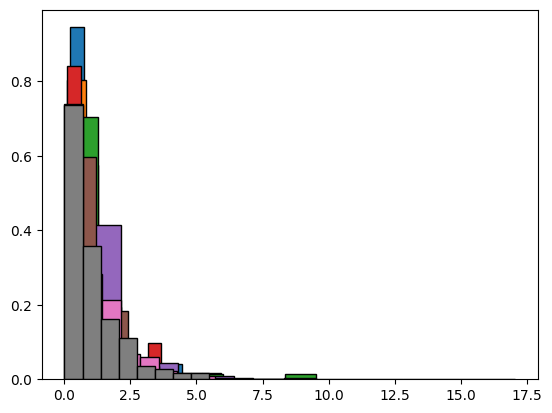

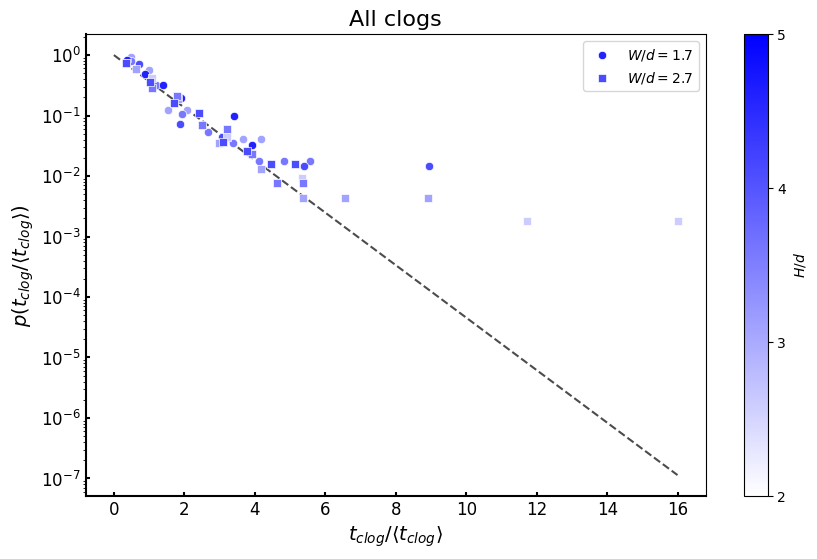

In [28]:
# Flow pdf, both perm and temp clogs

# Obtaining points for the pdf, based on a histogram
x_series = []
y_series = []
for i in range(len(time_flow_total)):
    if not math.isnan(mean_flow_total[i]):
        data_series = plt.hist(time_flow_total[i] / mean_flow_total[i], bins = 8, density = True, edgecolor = 'black')
        y = data_series[0]
        temp = data_series[1]
        
        x = []
        for j in range(len(temp) - 1):
            x.append((temp[j+1] - temp[j])/2 + temp[j]) # Appending the midpoint of each bin

        x_series.append(x)
        y_series.append(y)

#Line of best fit
x_fit = np.linspace(0, np.max(x_series), 1000)
y_fit = np.exp(-x_fit)


# Aesthetics
plt.figure(figsize=(10, 6))
cmap = mcolors.LinearSegmentedColormap.from_list('white_to_blue', ['white', 'blue'])
norm = mcolors.Normalize(vmin=2, vmax=5)
colors = cmap(norm([3.1, 3.6, 4.1, 4.6, 2.6, 3.1, 3.6, 4.1]))
ax = sns.lineplot(x=x_fit, y=y_fit, color='black', zorder=1, alpha=0.7)
ax.lines[0].set_linestyle("--")

for i, (x, y) in enumerate(zip(x_series, y_series)):
    marker = 'o' if i < 4 else 's'
    if i == 3:
        sns.scatterplot(x=x, y=y, color=colors[i], marker=marker, label=r'$W/d=1.7$')
    elif i == 7:
        sns.scatterplot(x=x, y=y, color=colors[i], marker=marker, label=r'$W/d=2.7$')
    else:
        sns.scatterplot(x=x, y=y, color=colors[i], marker=marker)

ax.set_yscale('log')
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=3, direction='in', bottom=True, left=True)
plt.ylabel(r'$ p(t_{clog} / \langle t_{clog} \rangle)$', fontsize=14, fontname='Times New Roman')
plt.xlabel(r'$ t_{clog} / \langle t_{clog} \rangle$', fontsize=14, fontname='Times New Roman')
plt.title(r'All clogs', fontsize=16)
plt.legend()
ax.grid(False)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, ticks=np.linspace(2, 5, 4))
cbar.set_label(r'$H/d$', fontsize=10)
cbar.ax.set_yticklabels([2, 3, 4, 5])

# Saving figures
plt.savefig(root_directory + 'Figures/pdf_all_clogs.eps', format='eps')
plt.savefig(root_directory + 'Figures/pdf_all_clogs.jpg', format='jpg', dpi=500)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


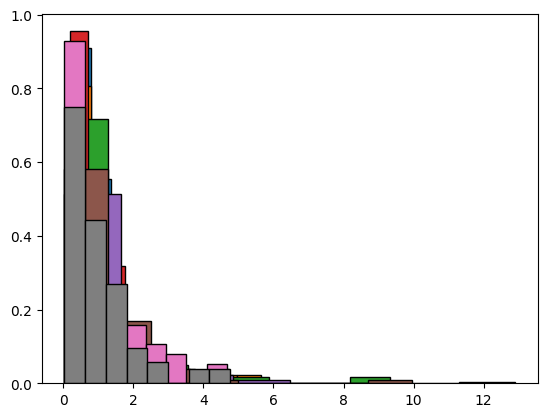

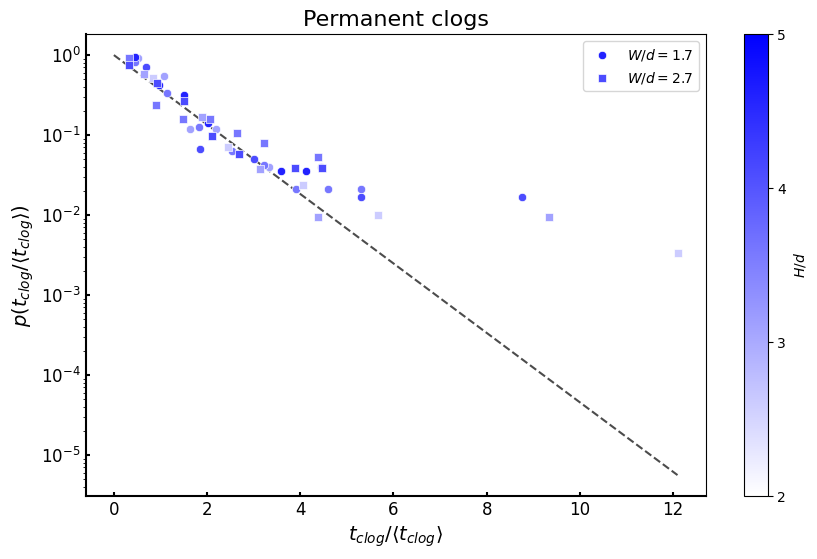

In [31]:
# Flow pdf, perm

# Obtaining points for the pdf, based on a histogram
x_series = []
y_series = []
for i in range(len(time_flow_perm)):
    bin_number = 8
    if not math.isnan(mean_flow_perm[i]):
        arr = plt.hist(time_flow_perm[i] / mean_flow_perm[i], bins = bin_number, density = True, edgecolor = 'black')
        y = arr[0]
        temp = arr[1]
        
        x = []
        for j in range(len(temp) - 1):
            x.append((temp[j + 1] - temp[j])/2 + temp[j])

        x_series.append(x)
        y_series.append(y)

# Line of best fit
max_x_value = 0
for i in x_series:
    for j in i:
        if j > max_x_value:
            max_x_value = j
x_fit = np.linspace(0, max_x_value, 1000)
y_fit = np.exp(-x_fit)


# Aesthetics
plt.figure(figsize=(10, 6))
cmap = mcolors.LinearSegmentedColormap.from_list('white_to_blue', ['white', 'blue'])
norm = mcolors.Normalize(vmin=2, vmax=5)
colors = cmap(norm([3.1, 3.6, 4.1, 4.6, 2.6, 3.1, 3.6, 4.1]))
ax = sns.lineplot(x=x_fit, y=y_fit, color='black', zorder=1, alpha=0.7)
ax.lines[0].set_linestyle("--")

for i, (x, y) in enumerate(zip(x_series, y_series)):
    marker = 'o' if i < 4 else 's'
    if i == 3:
        sns.scatterplot(x=x, y=y, color=colors[i], marker=marker, label=r'$W/d=1.7$')
    elif i == 7:
        sns.scatterplot(x=x, y=y, color=colors[i], marker=marker, label=r'$W/d=2.7$')
    else:
        sns.scatterplot(x=x, y=y, color=colors[i], marker=marker)

ax.set_yscale('log')
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=3, direction='in', bottom=True, left=True)
plt.ylabel(r'$ p(t_{clog} / \langle t_{clog} \rangle)$', fontsize=14, fontname='Times New Roman')
plt.xlabel(r'$ t_{clog} / \langle t_{clog} \rangle$', fontsize=14, fontname='Times New Roman')
plt.title(r'Permanent clogs', fontsize=16)
plt.legend()
ax.grid(False)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, ticks=np.linspace(2, 5, 4))
cbar.set_label(r'$H/d$', fontsize=10)
cbar.ax.set_yticklabels([2, 3, 4, 5])

# Saving figures
plt.savefig(root_directory + 'Figures/pdf_permanent_clogs.eps', format='eps')
plt.savefig(root_directory + 'Figures/pdf_permanent_clogs.jpg', format='jpg', dpi=500)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


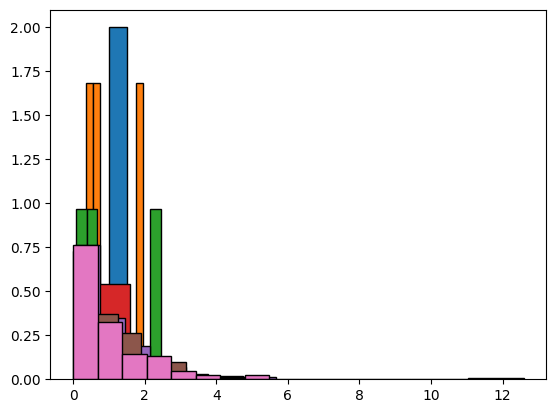

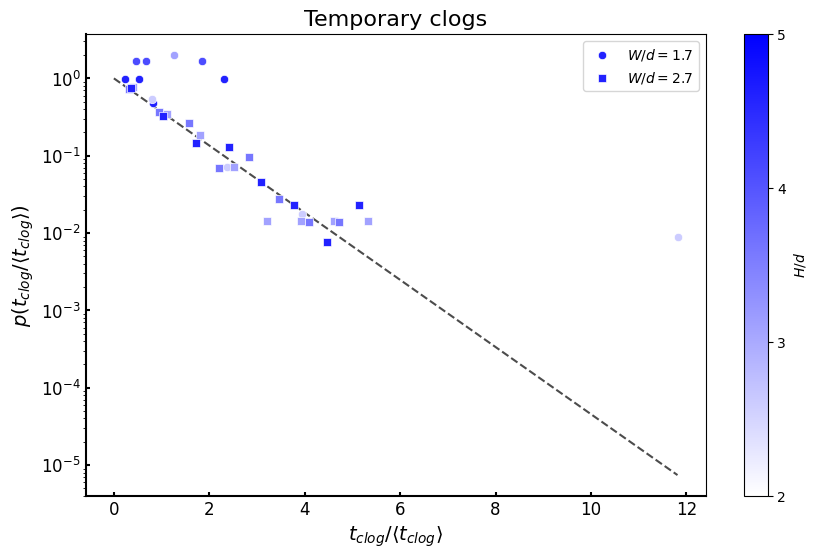

In [35]:
# Flow pdf, temporary

# Obtaining points for the pdf, based on a histogram
x_series = []
y_series = []
for i in range(len(time_flow_temp)):
    if i < 2: # Adjusting bin number to have more consistent data, not sure if this is acceptable?
        bin_number = 2
    else:
        bin_number = 8
    if not math.isnan(mean_flow_temp[i]):
        arr = plt.hist(time_flow_temp[i] / mean_flow_temp[i], bins = bin_number, density = True, edgecolor = 'black')
        y = arr[0]
        temp = arr[1]
        
        x = []
        for j in range(len(temp) - 1):
            x.append((temp[j + 1] - temp[j])/2 + temp[j])

        x_series.append(x)
        y_series.append(y)

# Line of best fit
max_x_value = 0
for i in x_series:
    for j in i:
        if j > max_x_value:
            max_x_value = j
x_fit = np.linspace(0, max_x_value, 1000)
y_fit = np.exp(-x_fit)


# Aesthetics
plt.figure(figsize=(10, 6))
cmap = mcolors.LinearSegmentedColormap.from_list('white_to_blue', ['white', 'blue'])
norm = mcolors.Normalize(vmin=2, vmax=5)
colors = cmap(norm([3.1, 4.1, 4.6, 2.6, 3.1, 3.6, 4.1]))
ax = sns.lineplot(x=x_fit, y=y_fit, color='black', zorder=1, alpha=0.7)
ax.lines[0].set_linestyle("--")

for i, (x, y) in enumerate(zip(x_series, y_series)):
    marker = 'o' if i < 4 else 's'
    if i == 2:
        sns.scatterplot(x=x, y=y, color=colors[i], marker=marker, label=r'$W/d=1.7$')
    elif i == 6:
        sns.scatterplot(x=x, y=y, color=colors[2], marker=marker, label=r'$W/d=2.7$')
    else:
        sns.scatterplot(x=x, y=y, color=colors[i], marker=marker)

ax.set_yscale('log')
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=3, direction='in', bottom=True, left=True)
plt.ylabel(r'$ p(t_{clog} / \langle t_{clog} \rangle)$', fontsize=14, fontname='Times New Roman')
plt.xlabel(r'$ t_{clog} / \langle t_{clog} \rangle$', fontsize=14, fontname='Times New Roman')
plt.title(r'Temporary clogs', fontsize=16)
plt.legend()
ax.grid(False)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, ticks=np.linspace(2, 5, 4))
cbar.set_label(r'$H/d$', fontsize=10)
cbar.ax.set_yticklabels([2, 3, 4, 5])

# Saving figures
plt.savefig(root_directory + 'Figures/pdf_temporary_clogs.eps', format='eps')
plt.savefig(root_directory + 'Figures/pdf_temporary_clogs.jpg', format='jpg', dpi=500)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


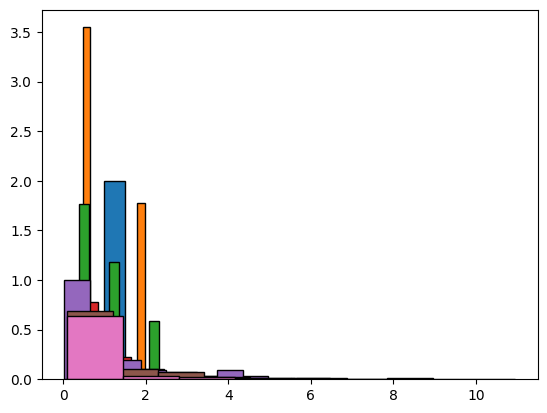

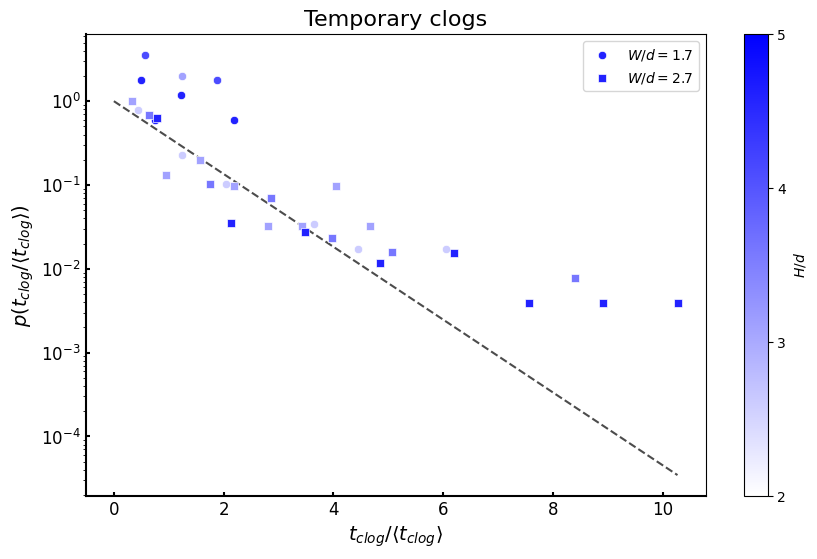

In [36]:
# Arrest time pdf, temporary clogs

x_series = []
y_series = []
for i in range(len(time_clogged_temp)):
    if i < 2: # Adjusting bin number to have more consistent data, not sure if this is acceptable?
        bin_number = 2
    else:
        bin_number = 8
    if not math.isnan(mean_clogged_temp[i]):
        arr = plt.hist(time_clogged_temp[i] / mean_clogged_temp[i], bins = bin_number, density = True, edgecolor = 'black')
        y = arr[0]
        temp = arr[1]
        
        x = []
        for j in range(len(temp) - 1):
            x.append((temp[j + 1] - temp[j])/2 + temp[j])

        x_series.append(x)
        y_series.append(y)

# Line of best fit
max_x_value = 0
for i in x_series:
    for j in i:
        if j > max_x_value:
            max_x_value = j
x_fit = np.linspace(0, max_x_value, 1000)
y_fit = np.exp(-x_fit)


# Aesthetics
plt.figure(figsize=(10, 6))
cmap = mcolors.LinearSegmentedColormap.from_list('white_to_blue', ['white', 'blue'])
norm = mcolors.Normalize(vmin=2, vmax=5)
colors = cmap(norm([3.1, 4.1, 4.6, 2.6, 3.1, 3.6, 4.1]))
ax = sns.lineplot(x=x_fit, y=y_fit, color='black', zorder=1, alpha=0.7)
ax.lines[0].set_linestyle("--")

for i, (x, y) in enumerate(zip(x_series, y_series)):
    marker = 'o' if i < 4 else 's'
    if i == 2:
        sns.scatterplot(x=x, y=y, color=colors[i], marker=marker, label=r'$W/d=1.7$')
    elif i == 6:
        sns.scatterplot(x=x, y=y, color=colors[2], marker=marker, label=r'$W/d=2.7$')
    else:
        sns.scatterplot(x=x, y=y, color=colors[i], marker=marker)

ax.set_yscale('log')
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=3, direction='in', bottom=True, left=True)
plt.ylabel(r'$ p(t_{clog} / \langle t_{clog} \rangle)$', fontsize=14, fontname='Times New Roman')
plt.xlabel(r'$ t_{clog} / \langle t_{clog} \rangle$', fontsize=14, fontname='Times New Roman')
plt.title(r'Temporary clogs', fontsize=16)
plt.legend()
ax.grid(False)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, ticks=np.linspace(2, 5, 4))
cbar.set_label(r'$H/d$', fontsize=10)
cbar.ax.set_yticklabels([2, 3, 4, 5])

# Saving figures
plt.savefig(root_directory + 'Figures/pdf_arrest_times_temporary_clogs.eps', format='eps')
plt.savefig(root_directory + 'Figures/pdf_arrest_times_temporary_clogs.jpg', format='jpg', dpi=500)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

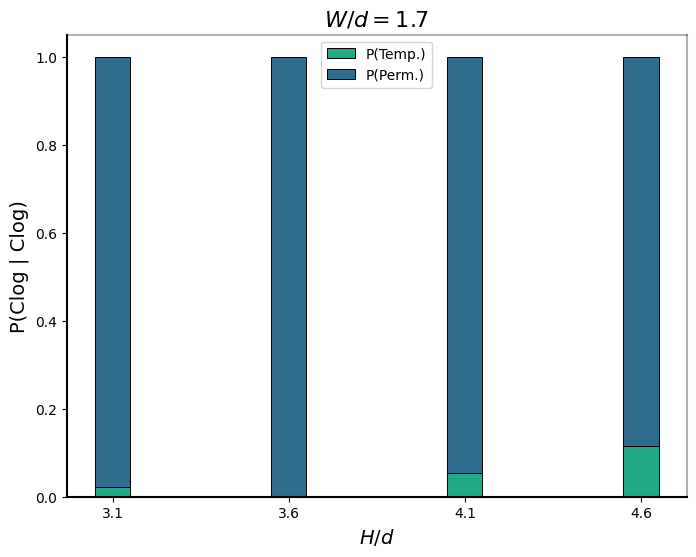

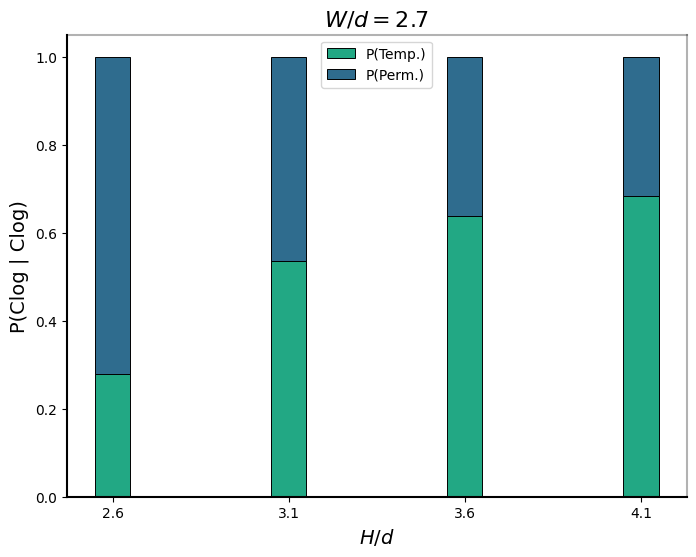

In [37]:
# Proportion of temporary and permanent clogs, VERY IMPORTANT

wd_hd_arr = ['w17_h31', 'w17_h36', 'w17_h41', 'w17_h46', 'w27_h26', 'w27_h31', 'w27_h36', 'w27_h41'] # Guideline, simply here to visualize what system each sub-array corresponds to.
hd_arr = [3.1, 3.6, 4.1, 4.6, 2.6, 3.1, 3.6, 4.1]

width = 0.1 
viridis = plt.cm.viridis


plt.figure(1)
fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(hd_arr[:4], probability_temp[:4], width, label='P(Temp.)', color=viridis(0.6), edgecolor='black', linewidth=0.7)
rects2 = ax.bar(hd_arr[:4], probability_perm[:4], width, bottom=probability_temp[:4], label='P(Perm.)', color=viridis(0.35), edgecolor='black', linewidth=0.7)
plt.xlabel(r'$H/d$', fontsize=14)
plt.ylabel('P(Clog | Clog)', fontsize=14)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_color((0, 0, 0, 0.3)) 
ax.spines['top'].set_color((0, 0, 0, 0.3))   
ax.spines['right'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.set_xticks(hd_arr[:4])
ax.set_xticklabels([str(x) for x in hd_arr[:4]])
plt.title(r'$W/d = 1.7$', fontsize=16, fontweight="bold")
plt.legend(loc='upper center')

# Saving figures
plt.savefig(root_directory + 'Figures/bar_plot_wd=1.7.eps', format='eps')
plt.savefig(root_directory + 'Figures/bar_plot_wd=1.7.jpg', format='jpg', dpi=500)

plt.figure(2)
fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(hd_arr[4:], probability_temp[4:], width, label='P(Temp.)', color=viridis(0.6), edgecolor='black', linewidth=0.7)
rects2 = ax.bar(hd_arr[4:], probability_perm[4:], width, bottom=probability_temp[4:], label='P(Perm.)', color=viridis(0.35), edgecolor='black', linewidth=0.7)
plt.xlabel(r'$H/d$', fontsize=14)
plt.ylabel('P(Clog | Clog)', fontsize=14)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_color((0, 0, 0, 0.3)) 
ax.spines['top'].set_color((0, 0, 0, 0.3))   
ax.spines['right'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.set_xticks(hd_arr[4:])
ax.set_xticklabels([str(x) for x in hd_arr[4:]])
plt.legend(loc='upper center')
plt.title(r'$W/d = 2.7$', fontsize=16, fontweight="bold")

# Saving figures
plt.savefig(root_directory + 'Figures/bar_plot_wd=2.7.eps', format='eps')
plt.savefig(root_directory + 'Figures/bar_plot_wd=2.7.jpg', format='jpg', dpi=500)


C:\Users\escud\AppData\Local\Temp\ipykernel_31312\3616627001.py:39: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_series_float, y_series_float, p0=[1, 1])
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


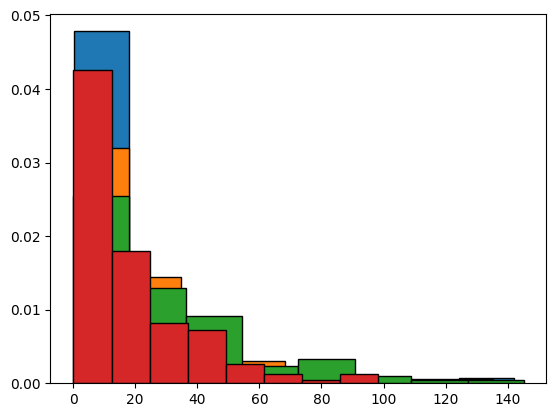

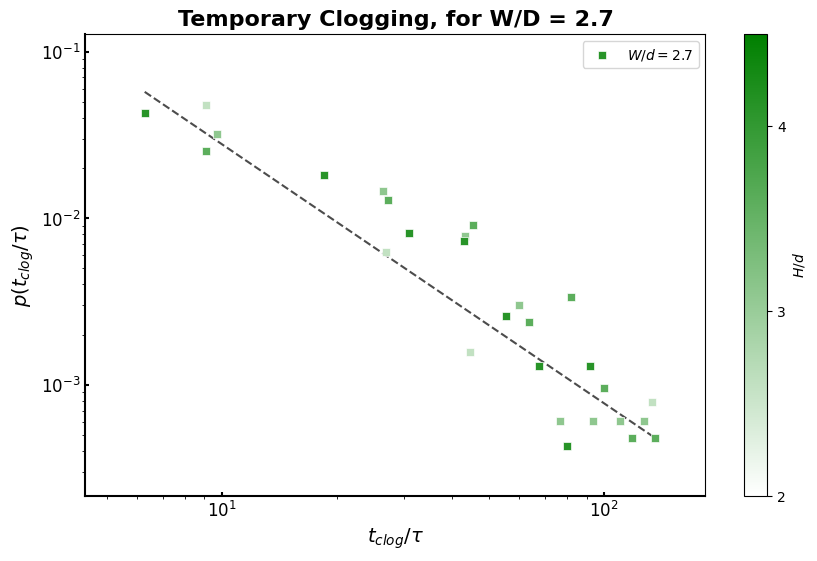

In [38]:
# PDF scaled by Stokes' time

# Stokes time calculation
Q = 1 #ml.min
d = 0.58 #mm

def st(wd,hd):
    A = wd * hd * d**2
    up = Q/A * 1000 / 60 # mm/s
    return np.float64(d/up) # s

stokes_time = [st(1.7, 3.1), st(1.7, 3.6), st(1.7, 4.1), st(1.7, 4.6), st(2.7, 2.6), st(2.7, 3.1), st(2.7, 3.6), st(2.7, 4.1)]

# Array calculation
x_series = []
y_series = []
for i in range(len(time_flow_temp) - 4):
    bin_number = 8

    if len(time_flow_temp[i + 4]) > 0: # +4, because we are only analyzing the events of W/d=2.7, since they are the only ones with temporary clogs.
        arr = plt.hist(time_flow_temp[i + 4] / stokes_time[i + 4], bins = bin_number, density = True, edgecolor = 'black')
        y = arr[0]
        temp = arr[1]
        
        x = []
        for j in range(len(temp) - 1):
            x.append((temp[j + 1] - temp[j])/2 + temp[j])

        x_series.append(x)
        y_series.append(y)

# Line of best fit
def func(x, a, b):
    return 1 * x**(-a) # Enforcing value of cubic coefficient, good idea? 

x_series_float = [float(item) for sublist in x_series for item in sublist]
y_series_float = [float(item) for sublist in y_series for item in sublist]

popt, pcov = curve_fit(func, x_series_float, y_series_float, p0=[1, 1])
a = popt[0]
b = popt[1]
x_fit = np.linspace(min(x_series_float), max(x_series_float), 1000)
y_fit = func(x_fit, a, b)

# Aesthetics
plt.figure(figsize=(10, 6))
cmap = mcolors.LinearSegmentedColormap.from_list('white_to_green', ['white', 'green'])
norm = mcolors.Normalize(vmin=2, vmax=4.5)
colors = cmap(norm([2.6, 3.1, 3.6, 4.1]))
ax = sns.lineplot(x=x_fit, y=y_fit, color='black', zorder=1, alpha=0.7)
ax.lines[0].set_linestyle("--")

for i, (x, y) in enumerate(zip(x_series, y_series)):
    marker = 's'
    if i == 3:
        sns.scatterplot(x=x, y=y, color=colors[i], marker=marker, label=r'$W/d=2.7$')
    else:
        sns.scatterplot(x=x, y=y, color=colors[i], marker=marker)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(bottom=min([0.5 * min(y) for y in y_series if min(y) > 0]), top = 3 * max(y))
ax.set_xlim(left=min([0.7 * min(x) for x in x_series if min(x) > 0]), right=2 * max(x))
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=3, direction='in', bottom=True, left=True)
plt.ylabel(r'$ p(t_{clog} /  \tau )$', fontsize=14, fontname='Times New Roman')
plt.xlabel(r'$ t_{clog} /  \tau $', fontsize=14, fontname='Times New Roman')
plt.title('Temporary Clogging, for W/D = 2.7', fontsize=16, fontweight="bold")
plt.legend()
ax.grid(False)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, ticks=np.linspace(2, 5, 4))
cbar.set_label(r'$H/d$', fontsize=10)
cbar.ax.set_yticklabels([2, 3, 4, 5])  # Labels from 2 to 5

plt.savefig(root_directory + 'Figures/pdf_temporary_clogs_stokes_time.eps', format='eps')
plt.savefig(root_directory + 'Figures/pdf_temporary_clogs_stokes_time.jpg', format='jpg', dpi=500)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


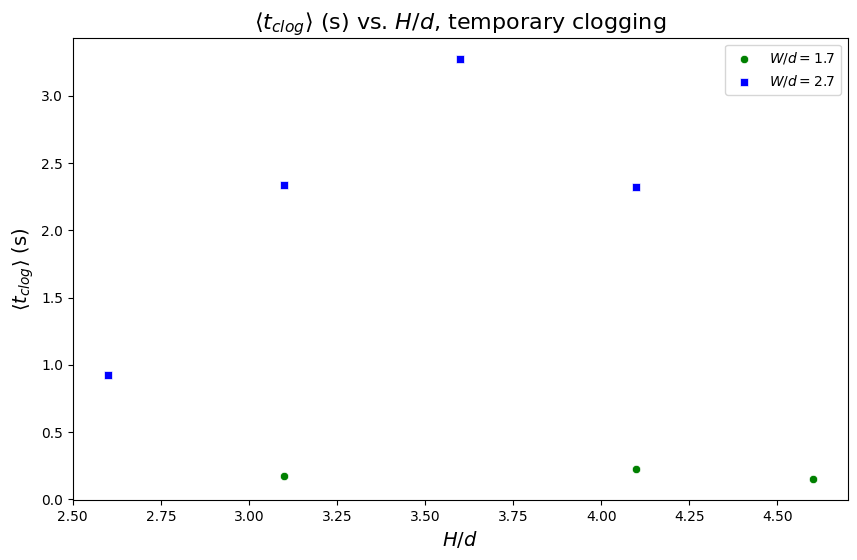

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


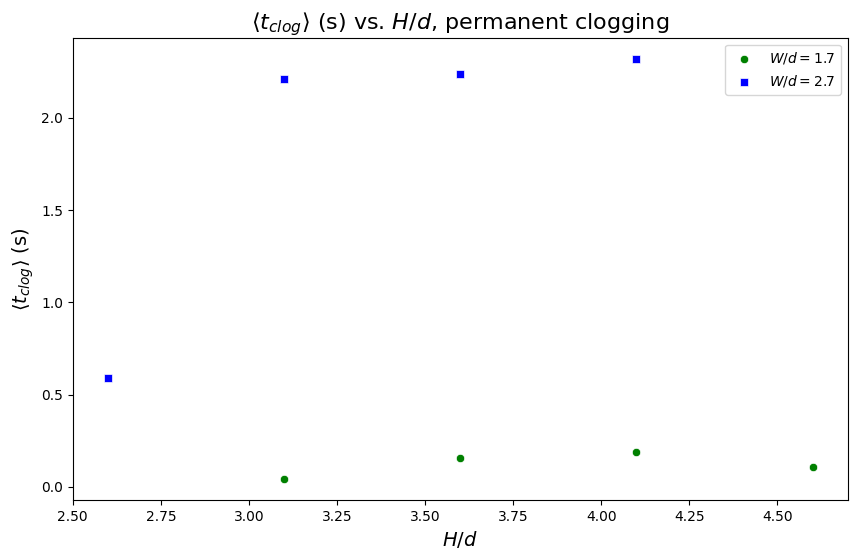

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


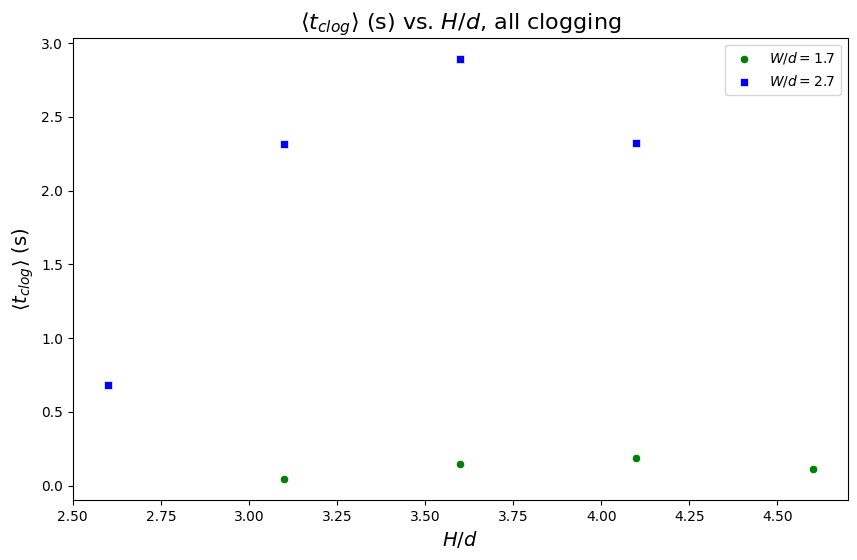

In [39]:
# Mean clog/flow times vs. H/d

wd_arr = [1.7, 1.7, 1.7, 1.7, 2.7, 2.7, 2.7, 2.7]
hd_arr = [3.1, 3.6, 4.1, 4.6, 2.6, 3.1, 3.6, 4.1]


# Temp

plt.figure(figsize=(10,6))
label = f'$W/d = 1.7$'
marker = 'o'
color = 'green'
sns.scatterplot(x=hd_arr[:4], y=mean_flow_temp[:4], label=label, color=color, marker=marker)

label = f'$W/d = 2.7$'
marker = 's'
color = 'blue'
sns.scatterplot(x=hd_arr[4:], y=mean_flow_temp[4:], label=label, color=color, marker=marker)

plt.xlabel(r'$H/d$', fontsize=14)
ax.set_yscale('log')
plt.ylabel(r'$\langle t_{clog} \rangle$ (s)', fontsize=14)
plt.title(r'$\langle t_{clog} \rangle$ (s) vs. $H/d$, temporary clogging', fontsize=16)
# Saving figures
plt.savefig(root_directory + 'Figures/scatterplot_mean_clog_time_temporary.eps', format='eps')
plt.savefig(root_directory + 'Figures/scatterplot_mean_clog_time_temporary.jpg', format='jpg', dpi=500)
plt.show()

# Perm

plt.figure(figsize=(10,6))
label = f'$W/d = 1.7$'
marker = 'o'
color = 'green'
sns.scatterplot(x=hd_arr[:4], y=mean_flow_perm[:4], label=label, color=color, marker=marker)

label = f'$W/d = 2.7$'
marker = 's'
color = 'blue'
sns.scatterplot(x=hd_arr[4:], y=mean_flow_perm[4:], label=label, color=color, marker=marker)

plt.xlabel(r'$H/d$', fontsize=14)
ax.set_yscale('log')
plt.ylabel(r'$\langle t_{clog} \rangle$ (s)', fontsize=14)
plt.title(r'$\langle t_{clog} \rangle$ (s) vs. $H/d$, permanent clogging', fontsize=16)
# Saving figures
plt.savefig(root_directory + 'Figures/scatterplot_mean_clog_time_permanent.eps', format='eps')
plt.savefig(root_directory + 'Figures/scatterplot_mean_clog_time_permanent.jpg', format='jpg', dpi=500)
plt.show()

# Total

plt.figure(figsize=(10,6))
label = f'$W/d = 1.7$'
marker = 'o'
color = 'green'
sns.scatterplot(x=hd_arr[:4], y=mean_flow_total[:4], label=label, color=color, marker=marker)

label = f'$W/d = 2.7$'
marker = 's'
color = 'blue'
sns.scatterplot(x=hd_arr[4:], y=mean_flow_total[4:], label=label, color=color, marker=marker)

plt.xlabel(r'$H/d$', fontsize=14)
ax.set_yscale('log')
plt.ylabel(r'$\langle t_{clog} \rangle$ (s)', fontsize=14)
plt.title(r'$\langle t_{clog} \rangle$ (s) vs. $H/d$, all clogging', fontsize=16)
# Saving figures
plt.savefig(root_directory + 'Figures/scatterplot_mean_clog_time_all.eps', format='eps')
plt.savefig(root_directory + 'Figures/scatterplot_mean_clog_time_all.jpg', format='jpg', dpi=500)
plt.show()